In [1]:
import pandas as pd
import torch
import transformers
import matplotlib.pyplot as plt


from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from huggingface_hub import notebook_login, PyTorchModelHubMixin

In [2]:
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

In [3]:
df_train = pd.read_csv("data/train_unclean.csv.zip")
df_val = pd.read_csv("data/val_unclean.csv.zip")
df_test = pd.read_csv("data/test_unclean.csv.zip")

In [4]:
genre_mapping = {"edm": 0, "r&b": 1, "rap": 2, "rock": 3, "pop": 4}

In [5]:
audio_features = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence",
]

In [6]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")

In [7]:
# using lyrics + audio features as input to the model
class LyricsAudioDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.lyrics = dataframe.lyrics
        self.audio = dataframe[audio_features]
        self.targets = self.data.playlist_genre.map(genre_mapping)
        self.max_len = max_len

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, index):
        lyrics = str(self.lyrics[index])
        lyrics = " ".join(lyrics.split())

        inputs = self.tokenizer.encode_plus(
            lyrics,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "audio": torch.tensor(self.audio.iloc[index].values, dtype=torch.float),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

In [8]:
training_set = LyricsAudioDataset(df_train, tokenizer, MAX_LEN)
validation_set = LyricsAudioDataset(df_val, tokenizer, MAX_LEN)
testing_set = LyricsAudioDataset(df_test, tokenizer, MAX_LEN)

In [9]:
train_params = {"batch_size": TRAIN_BATCH_SIZE, "shuffle": True, "num_workers": 0}
val_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": False, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

In [10]:
class DistilBERTClass(torch.nn.Module, PyTorchModelHubMixin):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-cased")
        self.pre_classifier = torch.nn.Linear(768 + len(audio_features), 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids, audio):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = torch.cat((pooler, audio), 1)
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

    def freeze_bert_encoder(self):
        for param in self.l1.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.l1.parameters():
            param.requires_grad = True

In [11]:
model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [12]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [13]:
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx == targets).sum().item()
    return n_correct

In [14]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()

    print(f"Training Epoch: {epoch + 1}")

    for _, data in tqdm(enumerate(training_loader, 0), total=len(training_loader)):
        ids = data["ids"].to(device, dtype=torch.long)
        mask = data["mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        audio = data["audio"].to(device, dtype=torch.float)
        targets = data["targets"].to(device, dtype=torch.long)

        # Forward pass through the model
        outputs = model(ids, mask, token_type_ids, audio)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()

        # Calculate and accumulate correct predictions
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_accuracy = (n_correct * 100) / nb_tr_examples
    epoch_loss = tr_loss / nb_tr_steps

    print(f"\nTotal Accuracy for Epoch {epoch + 1}: {total_accuracy:.2f}%")
    print(f"Epoch Loss: {epoch_loss:.4f}")
    print(f"Epoch Accuracy: {total_accuracy:.2f}%\n")

    return epoch_loss, total_accuracy

In [15]:
def plot_training_stats(loss_list, accuracy_list):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label="Training Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label="Training Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
loss_list = []
accuracy_list = []

for epoch in range(EPOCHS):
    epoch_loss, total_accuracy = train(epoch)
    loss_list.append(epoch_loss)
    accuracy_list.append(total_accuracy)

Training Epoch: 1


100%|██████████| 125/125 [00:17<00:00,  7.33it/s]



Total Accuracy for Epoch 1: 24.40%
Epoch Loss: 1.7848
Epoch Accuracy: 24.40%

Training Epoch: 2


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]



Total Accuracy for Epoch 2: 35.20%
Epoch Loss: 1.5458
Epoch Accuracy: 35.20%

Training Epoch: 3


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]



Total Accuracy for Epoch 3: 46.40%
Epoch Loss: 1.3019
Epoch Accuracy: 46.40%

Training Epoch: 4


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]



Total Accuracy for Epoch 4: 50.80%
Epoch Loss: 1.1876
Epoch Accuracy: 50.80%

Training Epoch: 5


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]



Total Accuracy for Epoch 5: 64.80%
Epoch Loss: 0.8835
Epoch Accuracy: 64.80%

Training Epoch: 6


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]



Total Accuracy for Epoch 6: 82.20%
Epoch Loss: 0.5765
Epoch Accuracy: 82.20%

Training Epoch: 7


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]



Total Accuracy for Epoch 7: 94.60%
Epoch Loss: 0.2803
Epoch Accuracy: 94.60%

Training Epoch: 8


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]



Total Accuracy for Epoch 8: 97.80%
Epoch Loss: 0.1494
Epoch Accuracy: 97.80%

Training Epoch: 9


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]



Total Accuracy for Epoch 9: 98.40%
Epoch Loss: 0.1001
Epoch Accuracy: 98.40%

Training Epoch: 10


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Total Accuracy for Epoch 10: 99.80%
Epoch Loss: 0.0548
Epoch Accuracy: 99.80%



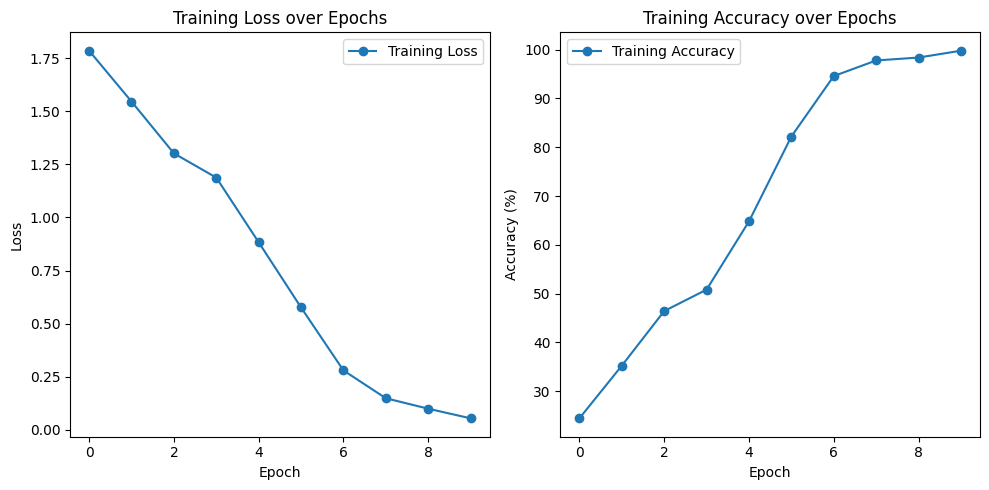

In [17]:
plot_training_stats(loss_list, accuracy_list)

In [18]:
def validation(model, validation_loader):
    model.eval()
    n_correct = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0

    print("Validation:")
    with torch.no_grad(), tqdm(total=len(validation_loader)) as pbar:
        for _, data in enumerate(validation_loader, 0):
            ids = data["ids"].to(device, dtype=torch.long)
            mask = data["mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            audio = data["audio"].to(device, dtype=torch.float)
            targets = data["targets"].to(device, dtype=torch.long)

            # Forward pass through the model
            outputs = model(ids, mask, token_type_ids, audio)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()

            # Calculate correct predictions
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)
            pbar.update(1)

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples

    print(f"Validation Loss Epoch: {epoch_loss:.4f}")
    print(f"Validation Accuracy Epoch: {epoch_accu:.2f}%\n")

    return epoch_accu

In [19]:
validation_accuracy = validation(model, validation_loader)

Validation:


100%|██████████| 510/510 [00:13<00:00, 38.03it/s]

Validation Loss Epoch: 2.1205
Validation Accuracy Epoch: 43.63%

